# Regression Project - Zillow

Name: Craig Calzado

<h2>Goals</h2>

- Construct an ML Regression model that predict propery tax assessed values of Single Family Properties using attributes of the properties.

- Find the key drivers of property value for single family properties.

- Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.

- Make recommendations on what works or doesn't work in prediction these homes' values.


<h2>Executive Summary</h2>

- There were four drivers of property value; Square footage(sqft), Bedrooms, Bathrooms, and lot squar footage(lotsqft).
- LassaLars model was the best out performing model. The baseline was set at $328,336.00 off of actual value. LassaLars model was able to predict the value of the property with $208,614.82 off of the actual value. Thats approximately 120k improvement in property value prediction.
- LassaLars was best model as determined by RMSE and R^2.
- County had an effect on tax value, but was not one of the most important drivers.


<h2>Imports</h2>

In [1]:
# imports
# custom function imports
import wrangle
import prepare
import project_models # contains all the functions for the project
# remove warnings
import warnings
warnings.filterwarnings('ignore')


<h2>Data Acquisition/Wrangle</h2>

Utilized wrangle.py to acquire data from codeup SQL database.

<h6>Query:

SELECT parcelid, bathroomcnt, bedroomcnt, finishedsquarefeet12, fips, lotsizesquarefeet, yearbuilt, taxvaluedollarcnt, logerror, transactiondate, taxamount

FROM properties_2017 

LEFT JOIN propertylandusetype USING (propertylandusetypeid)

JOIN predictions_2017 USING (parcelid)

WHERE propertylandusedesc IN ('Single Family Residential');</h6>

In [2]:
# utilize wrangle.py to load data
df = wrangle.get_zillow_project_data()
df.head() # check the first 5 rows of the data

Let me get that for you...


,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,logerror,transactiondate,taxamount
0,12797413,2.0,4.0,1178.0,6037.0,6213.0,1951.0,223459.0,0.038661,2017-01-11,2864.03
1,10808520,3.0,3.0,2287.0,6037.0,10249.0,1978.0,753587.0,0.000974,2017-01-11,9115.66
2,12961285,5.0,5.0,3135.0,6037.0,11772.0,1951.0,2132481.0,1.457087,2017-01-11,24025.64
3,14195775,2.5,4.0,2990.0,6059.0,15300.0,1982.0,599991.0,0.066588,2017-01-11,7187.12
4,11243022,2.0,2.0,1080.0,6037.0,108228.0,1973.0,130028.0,-0.008227,2017-01-11,1559.50


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   parcelid              52442 non-null  int64  
 1   bathroomcnt           52442 non-null  float64
 2   bedroomcnt            52442 non-null  float64
 3   finishedsquarefeet12  52195 non-null  float64
 4   fips                  52442 non-null  float64
 5   lotsizesquarefeet     52073 non-null  float64
 6   yearbuilt             52326 non-null  float64
 7   taxvaluedollarcnt     52441 non-null  float64
 8   logerror              52442 non-null  float64
 9   transactiondate       52442 non-null  object 
 10  taxamount             52438 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 4.4+ MB


<h2>Data Preparation</h2>

- Identified the tax rate for the county using the taxvaluedollarcnt and taxamount columns.

- Dropped parcelid, taxamount, and transactiondate columns.

- Dropped null rows for bathroomcnt, bedroomcnt, finishedsquarefeet12, fips, lotsizesquarefeet.

- Imputed missing values for yearbuild.

- Renamed columns for consistency.

- Removed outliers.

- Split data into training, validate, and test set.

In [4]:
# Function that identifies the tax rate for each county from project_models.py
project_models.get_tax_rate(df)

Median tax rate for Los Angelos 1.27
Median tax rate for Onange 1.16
Median tax rate for Ventura 1.12


In [5]:
# prep the data for modeling and feature engineering
df = wrangle.zillow_proj_prep(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51834 entries, 0 to 52441
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        51834 non-null  float64
 1   bedrooms         51834 non-null  float64
 2   sqft             51834 non-null  float64
 3   county_fips      51834 non-null  float64
 4   lotsqft          51834 non-null  float64
 5   year             51834 non-null  float64
 6   value            51834 non-null  float64
 7   logerror         51834 non-null  float64
 8   transactiondate  51834 non-null  object 
dtypes: float64(8), object(1)
memory usage: 4.0+ MB


In [6]:
# check data for nulls
df.isnull().sum()

bathrooms          0
bedrooms           0
sqft               0
county_fips        0
lotsqft            0
year               0
value              0
logerror           0
transactiondate    0
dtype: int64

In [7]:
# remove outliers
df = prepare.remove_outliers_fips(df, 1.5)

<h3>Split the data into train, validate, test</h3>

In [8]:
# split the dataframe into train, validate, and test
train, validate, test = wrangle.split_dataframe(df)
print(train.shape)
print(validate.shape)
print(test.shape)

(22979, 9)
(9849, 9)
(8208, 9)


<h2>Data Exploration</h2>

- Used a sample of 1000 from train dataset to create a correlation matrix.
- Created a visual representation of the correlation matrix.
- Generated questions and hypotheses based on the correlation matrix.
- Ran pearson correlation on the data to determine the most correlated features.
- Ran a t-test on the data to determine the most significant features.


<h3>Idenfify potential drivers of Value</h3>

- Kbest was used to identify the top 3 features that were most correlated with the value.
- The top 3 features were bedroomcnt, bathroomcnt, and sqft.
- pearsonr confirmed that the top 3 features were the most correlated with the value.
- ttest confirmed that the top 3 features were the most significant.

In [9]:
# create sample of train dataset for easier visualization
train_sample = train.sample(n=1000)
# create a pairplot of the sampled train dataset
#sns.pairplot(train_sample, hue = ('value'))

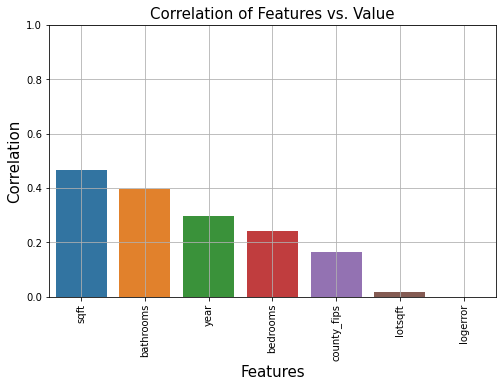

In [10]:
# correlation of all features vs. target
project_models.sample_corr(train_sample, 'value')

<h2>Questions:</h2>

- Is there a relationship between square footage and the tax value?
- Is there a relationship between the number of bathrooms and tax value?
- Is there a relationship between the number of bedrooms and tax value?
- Is there a relationship between the lot size and tax value?

<h2>Hypotheses;</h2>

- Alpha = .05 (95% confidence level)

<h3>Hypothesis #1 Square footage vs. Value</h3>

-  $H_0:$ There is no correlation between sqft and the value.
-  $H_a:$ There is a correlation between sqft and the value.

<h3>Hypothesis #2 Bathrooms vs. Value</h3>

-  $H_0:$ There is no correlation between Bathrooms and the value.
-  $H_a:$ There is a correlation between Bathrooms and the value.

<h3>Hypothesis #3 Bedrooms vs. Value</h3>

-  $H_0:$ There is no correlation between Bedrooms and the value.
-  $H_a:$ There is a correlation between Bedrooms and the value.

<h3>Hypoesis #4 Lot Sqft vs. Value</h3>

-  $H_0:$ There is no correlation between Lot Sqft and the value.
-  $H_a:$ There is a correlation between Lot Sqft and the value. 


In [11]:
# Pearsonr Correlation tests are used to check if two features are correlated
# the closer the correlation is to 1, the more correlated the features are
pearson_df = project_models.pearson_corr(train, 'value')
pearson_df

,feature,r,p
0,sqft,0.427263,0.000000e+00
1,bathrooms,0.359820,0.000000e+00
2,bedrooms,0.185379,9.455187e-177
3,lotsqft,0.016694,1.138600e-02


In [12]:
# t test are used to check if two features are statistically different
# the closer the p value is to 0, the more statistically significant the test
ttest_df = project_models.ttest_corr(train, 'value')
ttest_df

,feature,r,p
0,sqft,232.033871,0.0
1,bathrooms,233.102995,0.0
2,bedrooms,233.102265,0.0
3,lotsqft,228.816370,0.0


Split Train, Validate, and Test into X and y

In [13]:
# function that creates your X and y dataframes
X_train, y_train, X_validate, y_validate, X_test, y_test = project_models.create_X_y(train, validate, test)
# check the shape of the X and y dataframes
print('Shape of X_train is', X_train.shape)
print('Shape of y_train is', y_train.shape)
print('Shape of X_validate is', X_validate.shape)
print('Shape of y_validate is', y_validate.shape)
print('Shape of X_test is', X_test.shape)


Shape of X_train is (22979, 5)
Shape of y_train is (22979,)
Shape of X_validate is (9849, 5)
Shape of y_validate is (9849,)
Shape of X_test is (8208, 5)


In [14]:
# scale your X_train, X_validate, and X_test dataframes
X_train_scaled, X_validate_scaled, X_test_scaled = project_models.scale_X(X_train, X_validate, X_test)
# check the shape of the scaled X dataframes
print('Shape of X_train_scaled is', X_train_scaled.shape)
print('Shape of X_validate_scaled is', X_validate_scaled.shape)
print('Shape of X_test_scaled is', X_test_scaled.shape)

Shape of X_train_scaled is (22979, 5)
Shape of X_validate_scaled is (9849, 5)
Shape of X_test_scaled is (8208, 5)


In [15]:
# kbest function for X_train and y_train
project_models.kbest_X_y(X_train_scaled, y_train)

Index(['bathrooms', 'sqft', 'year'], dtype='object')
                       p            f
bathrooms   0.000000e+00  3417.285410
bedrooms   9.455187e-177   817.710591
sqft        0.000000e+00  5131.271628
lotsqft     1.138600e-02     6.405087
year       1.201392e-302  1425.193007 None


In [16]:
# Progressively eliminate features based on importance to the model using rfe
project_models.rfe(X_train_scaled, y_train)


(['bedrooms', 'sqft', 'lotsqft'],
          Var  Rank
 1   bedrooms     1
 2       sqft     1
 3    lotsqft     1
 0  bathrooms     2
 4       year     3)

In [17]:
# convert y to a dataframe
y_train, y_validate, y_test = project_models.y_dataframe(y_train, y_validate, y_test)

<h3>Baseline to compare against other models</h3>


- Base line was set at $328,336.00. Utilized the median value of the taxvaluedollarcnt column to set the baseline.

In [18]:
# create median baseline
y_train, y_validate, y_test = project_models.median_baseline(y_train, y_validate, y_test)
print(y_train.head())

          value  price_pred_median
31495  482254.0           328336.0
29824  711516.0           328336.0
41480  299124.0           328336.0
8979   127120.0           328336.0
2019   629603.0           328336.0


RMSE using Median
Train/In-Sample:  236525.22 
Validate/Out-of-Sample:  238483.92 
 
 R^2 using Mean
Train/In-Sample:  -0.0 
Validate/Out-of-Sample:  0.0


(None, <AxesSubplot:xlabel='value', ylabel='price_pred_median'>)

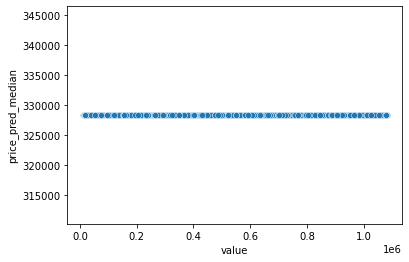

In [19]:
# function of the RMSE and R^2
project_models.rmse_r2(y_train, y_validate, y_test)

<h2>Modeling and evaluation</h2>

- Utilize linear regression to predict the value of the property.

    - OLS regression: Ordinary Least Squares $209,068.38 / $214,364.28 = $5,295.90 difference.

    - Lasso regression: Lasso regression $209,068.77 / $214,331.54 = $5,262.77 difference.
    
    - Tweedie regression: Tweedie regression $212,594.78 / $208,958.36 = $3,636.42 difference.

RMSE for OLS using LinearRegression
Training/In-Sample:  209068.38 
Validation/Out-of-Sample:  214364.28 
 
 R^2 using Mean
Train/In-Sample:  0.2 
Validate/Out-of-Sample:  0.2


(None, <AxesSubplot:xlabel='value', ylabel='price_pred_lm'>)

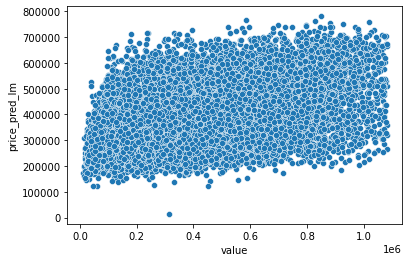

In [20]:
# function of the Linear regression, OLS
project_models.lm_ols(X_train_scaled, y_train, X_validate_scaled, y_validate)

RMSE for Lasso + Lars
Training/In-Sample:  209068.77 
Validation/Out-of-Sample:  214331.54 
 
 R^2 using Mean
Train/In-Sample:  0.2 
Validate/Out-of-Sample:  0.2


(None, <AxesSubplot:xlabel='value', ylabel='price_pred_lars'>)

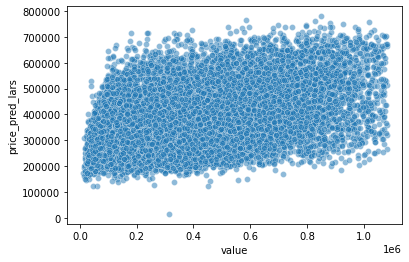

In [21]:
# function of the Lars Lasso Regression
project_models.lars_lasso(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  208958.36 
Validation/Out-of-Sample:  212594.78 
 
 R^2 using Mean
Train/In-Sample:  0.2 
Validate/Out-of-Sample:  0.2


(None,
 <AxesSubplot:xlabel='value', ylabel='price_pred_glm'>,
 <AxesSubplot:xlabel='value', ylabel='price_pred_glm'>)

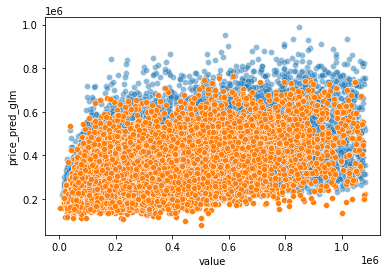

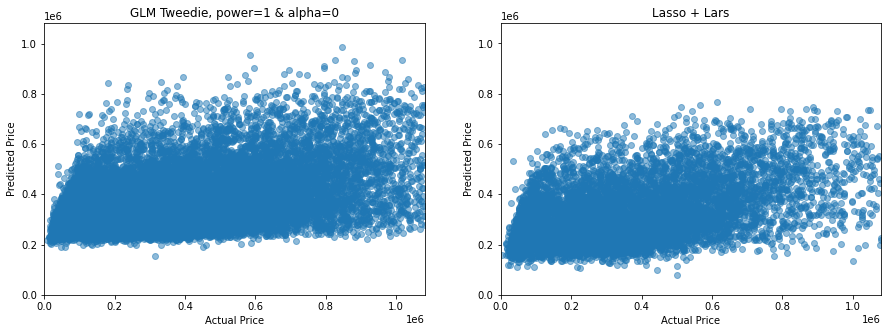

In [22]:
# Function of the Tweedie regression
project_models.glm_tweedie(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test)

RMSE for Lasso + Lars
 Test/Out-of-Sample:  208614.82 
 
 R^2 using Mean
 Test/Out-of-Sample:  0.22


(None, <AxesSubplot:xlabel='value', ylabel='price_pred_lars'>)

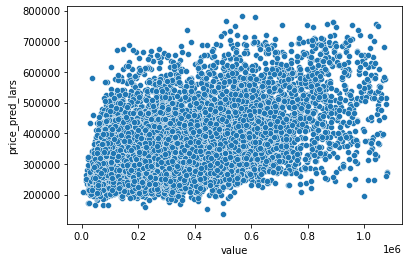

In [23]:
# Function that predicts test data
project_models.lars_test(X_test_scaled, y_test)

<h3>Conclusions:</h3>

- Baseline set at $328,336.00 as the median tax value in train dataset.
- Lasso regression was the best performing model.
- Lasso Test model achived $208,614.82 off of the actual value. Thats approximately 120k improvement in property value prediction.

<h3>Additional Info</h3>

- 